In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

class Point:
    def __init__(self,x,y,mass):
        self.x = x
        self.y = y
        self.mass = mass

class Rectangle:
    def __init__(self,x,y,w,h):
        # x,y = center of the Rectangle
        # w = edge to edge horizontal distance
        # h = edge to edge vertical distance
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y-h/2, y+h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y >= self.north_edge and point.y <= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='black'):
        #axis.add_patch(patches.Rectangle((self.x-self.w,self.y-self.h),self.w*2,self.h*2,fill=False))
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        # axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c='black', lw=1)
        axis.add_patch(patches.Rectangle((self.west_edge,self.south_edge),
        (self.east_edge-self.west_edge),
        (self.north_edge-self.south_edge),fill=False,color=color))
class Quadtree:
    def __init__(self,boundary,n = 4):

        self.boundary = boundary

        # choosing capacity(n) = 4, i.e. if particle number crosses 4 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []

        self.divided = False

    def subdivide(self):

        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2,y - h/2, w,h)
        self.northeast = Quadtree(ne,self.capacity);
        nw = Rectangle(x - w/2,y - h/2, w,h)
        self.northwest = Quadtree(nw,self.capacity);
        se = Rectangle(x + w/2,y + h/2, w,h)
        self.southeast = Quadtree(se,self.capacity);
        sw = Rectangle(x - w/2,y + h/2, w,h)
        self.southwest = Quadtree(sw,self.capacity);

        self.divided = True

    def insert(self,point):

        # If the point isn't in the boundary then stop!
        if self.boundary.contains(point) != True:
            return False

        # Check if the number of points exceed the capacity
        if len(self.points) < self.capacity:
            # if the point does not exceed then add the point,
            # to the list of points in the boundary
            self.points.append(point)
            return True
        # If the number of points exceed the given capacity then
        # subdivide the rectangular boundary into four parts

        # subdivide boundary
        if not self.divided:
            self.subdivide()

        return (self.northeast.insert(point) or
        self.northwest.insert(point) or
        self.southeast.insert(point) or
        self.southwest.insert(point))


    def query(self, boundary, found_points):
        """Find points in the quadtree that lie within a boundary."""
        if not self.boundary.intersects(boundary):
            # if the domain of this node does not interesect the search
            # region, we don't need to look in it for points.
            return False

        # Search this node's point to see if they lie within boundary
        for point in self.points:
            if boundary.contains(point):
                found_points.append(point)
        # if this node has children, search them too.
        if self.divided:
            self.northeast.query(boundary,found_points)
            self.northwest.query(boundary,found_points)
            self.southeast.query(boundary,found_points)
            self.southwest.query(boundary,found_points)
        return found_points


    def show(self,axis):
        self.boundary.show(axis)
        if self.divided:
            self.northeast.show(axis)
            self.northwest.show(axis)
            self.southeast.show(axis)
            self.southwest.show(axis)


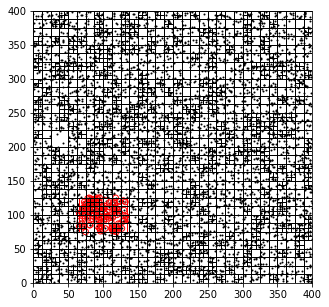

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rect
import utils
fig, ax = plt.subplots(figsize=(5,5))

# specs of Rectangle:
width = 400
height = 400
center_x = 200
center_y = 200
boundary = Rectangle(center_x,center_y,width,height)
qt = Quadtree(boundary, 4)

for i in range(5000):
    x = np.random.randint(0,400)
    y = np.random.randint(0,400)
    mass = np.random.randint(3,500)
    p = Point(x,y,mass)
    ax.scatter(p.x,p.y,s=1,c='black')
    qt.insert(p)

# give me points in this region
region = Rectangle(100,100,68,50)
found_points = []
qt.query(region,found_points)
ax.scatter([p.x for p in found_points],[p.y for p in found_points],
facecolors='none', edgecolors='r',s=32)
region.show(ax,color='red')
ax.set_xlim(center_x-width/2,center_x+width/2)
ax.set_ylim(center_y-height/2,center_y+height/2)

qt.show(ax)
plt.show()


In [112]:
#Main function :
# X0 -> X1
# @vectorize(['float32(float32, float32, float32, float32, float32, float32)'], target='cuda')
def step(mass:'arr', x0:'arr',y0:'arr',vx0:'arr',vy0: 'arr',dt=0.1, G = 1):
    
    x1 = x0 + vx0*dt
    y1 = y0 +vy0*dt
    
    vx1 = []
    vy1 = []
    #Loop over planets to find the distance:
    for i in range(len(x1)):
        x1self = x1[i]
        y1self = y1[i]
        ax = 0
        ay = 0
        for j in range(len(x0)):
            if i == j:
                continue
            x_dist = x1[j] - x1self
            y_dist = y1[j] - y1self
            Rsq = x_dist**2 + y_dist**2

            # Contribution from the jth mass:
            a = G*mass[j]/Rsq
            ax += a * x_dist/np.sqrt(Rsq)
            ay += a * y_dist/np.sqrt(Rsq)
        vx1.append(vx0[i] + ax*dt)
        vy1.append(vy0[i] + ay*dt)
        
    return x1,y1,np.array(vx1),np.array(vy1)

In [113]:
# Function to scale masses for their sizes
def scale_the_array(arr, min_=7, max_=300):
    l = []
    for element in arr:
        if arr.max() != arr.min():
            scaled_element = ((element - arr.min())/(arr.max()-arr.min()))*(max_-min_) + min_
            l.append(scaled_element)
        else:
            # Default size
            l = [20, 20]
            
    return np.array(l)

In [114]:
# masses
masses = np.array([100000, 950, 500])


# Initial x positions
x0 = np.array([0,72, 200])
# Initial y positions
y0 = np.array([0, 0, 0])
# Initial  
vx0 = np.array([0, 0, -5])
vy0 = np.array([0, -30, 12])

# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses) 

fig = plt.figure()
for time in range(300):
    x1,y1,vx1,vy1 = step(masses, x0, y0, vx0, vy0, dt=0.5)
    plt.scatter(x1[0],y1[0],c='y', s= scaled_masses[0])
    plt.scatter(x1[1],y1[1], c='g', s= scaled_masses[1])
    plt.scatter(x1[2], y1[2], c='c', s = scaled_masses[2])
    plt.xlim(-500, 500)
    plt.ylim(-500, 500)
    #plt.savefig(f"../IAPT Course Work/Animations/{time+1}.png")
    plt.show()
    print(f"frame: {time}/300")    
    clear_output(wait=True)
    x0 = x1
    y0 = y1
    vx0 = vx1
    vy0 = vy1




KeyboardInterrupt: 

In [115]:
pip install gravity-simulation==2.0.1

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\astro\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [116]:
import gravity_simulation

start calculation 2022-02-04 22:54:30.245703
100% calculation  completed :2022-02-04 22:54:52.752525
calculation complete succsefuly
start rendering 2022-02-04 22:54:54.236168
end rendering 2022-02-04 22:55:02.258845


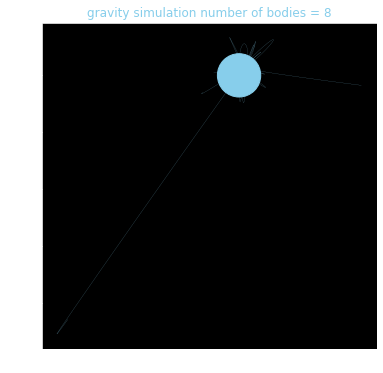

In [119]:
from gravity_simulation.gravity import GravityField
from gravity_simulation.gravity import Body

field = GravityField()
field.add_body(Body(15, 6, -np.cos(np.pi / 4)/100,
                0.01*np.cos(np.pi / 4), mass=30))
field.add_body(Body(6, 6, -np.cos(np.pi / 4)/100,
                0.01*np.cos(np.pi / 4), mass=50))
field.add_body(Body(-3, 0, np.cos(np.pi / 4)/(10*20),
                np.cos(np.pi / 4)/(10*20), mass=1500))
field.add_body(Body(-6, -6, -0.01*np.cos(np.pi / 4) /
                100, -0.001*np.cos(np.pi / 4), mass=60))
field.add_body(Body(-10, 6, -np.cos(np.pi / 4)/100,
                0.01*np.cos(np.pi / 4), mass=100))
field.add_body(Body(-19, 0, np.cos(np.pi / 4)/(10*20),
                np.cos(np.pi / 4)/(10*20), mass=100))
field.add_body(Body(-20, -6, -0.01*np.cos(np.pi / 4) /
                100, -0.001*np.cos(np.pi / 4), mass=60))
field.add_body(Body(30, 6, -np.cos(np.pi / 4)/100,
                0.01*np.cos(np.pi / 4), mass=100))

X, Y = field.run(17000, C=0.01)
field.save_animation(frames=80, figsize=(6, 6), reduce_size_body=5)

In [120]:
def simpson(f,a,b,n):
    h = (b-a)/n
    x = []
    yx = []
    i = 0
    while i<=n:
        x.append(a+i*h)
        yx.append(f(x[i]))
        i+=1
    
    I = 0
    j = 0
    while j<=n:
        if j == 0 or j == n:
            I += yx[j]
        elif j%2 != 0:
            I += 4*yx[j]
        else:
            I += 2*yx[j]
        j += 1
    I = (h/3)*I
    #print(yx)
    return I

In [123]:
simpson(lambda x:x*np.exp(-x),0,10,10000)

0.9995006007725946

In [ ]:
(np.sqrt((a**2)*(r**4)-(((r-u)**2)-(k**2)))*((r-u)**2-k**2))/(a*(r**4))

In [135]:
a = 10
u = 1
k = 2
def equ(x):
    eq = (np.sqrt((a**2)*(x**4)-(((x-u)**2)-(k**2)))*((x-u)**2-k**2))/(a*(x**4))


SyntaxError: invalid syntax (<ipython-input-135-72067bf1f20d>, line 5)

In [161]:
simpson(lambda r: (-np.sqrt(100*r**4 - ((r-1)**2-2**2))*((r-1)**2-2**2)/(100*r**4))**-1, 100000,0.0001,1000)

999822.360578116

In [ ]:
t = np.linspace(100,0,1000)
